In [1]:
import pylidc as pl
from pylidc.utils import consensus
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manim
from skimage.measure import find_contours

# Visualize patient scan

In [2]:
pid = 'LIDC-IDRI-0010'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

In [3]:
scan.patient_id

'LIDC-IDRI-0010'

In [4]:
nods = scan.cluster_annotations()

Loading dicom files ... This may take a moment.


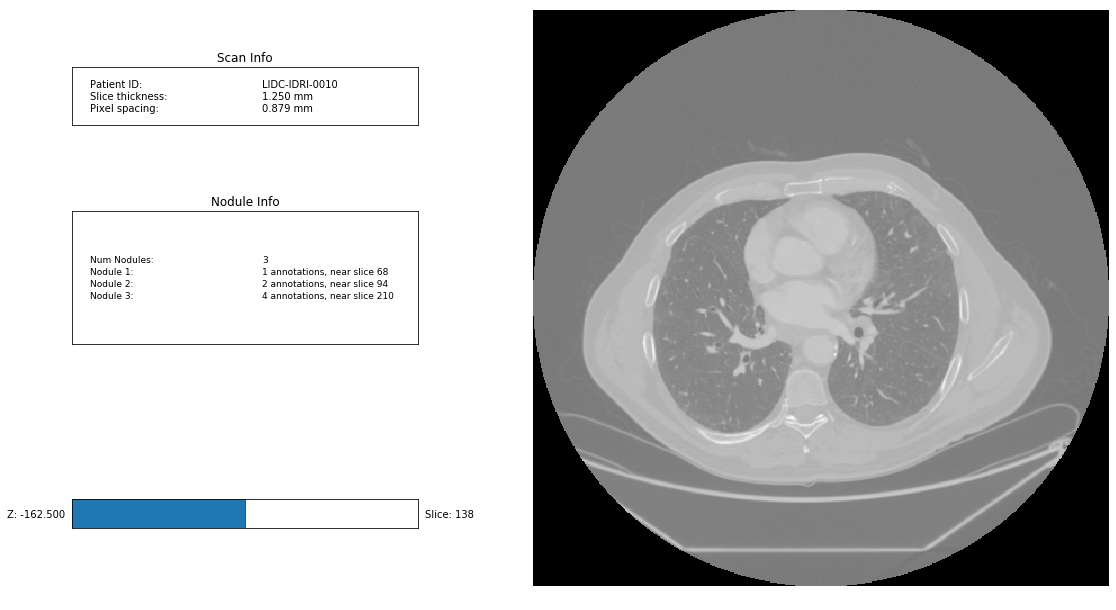

In [5]:
scan.visualize(annotation_groups=nods)

# Get annotation information

In [6]:
annotation_1 = scan.annotations[0]

In [7]:
print(scan.annotations[0]._nodule_id)

Nodule 001


In [8]:
annotation_1.print_formatted_feature_table()

Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Moderately Obvious       | 4 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid                    | 3 
Margin             | Sharp                    | 5 
Lobulation         | No Lobulation            | 1 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Moderately Suspicious    | 4 


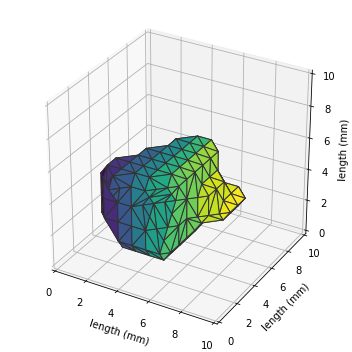

In [9]:
annotation_1.visualize_in_3d()

Loading dicom files ... This may take a moment.


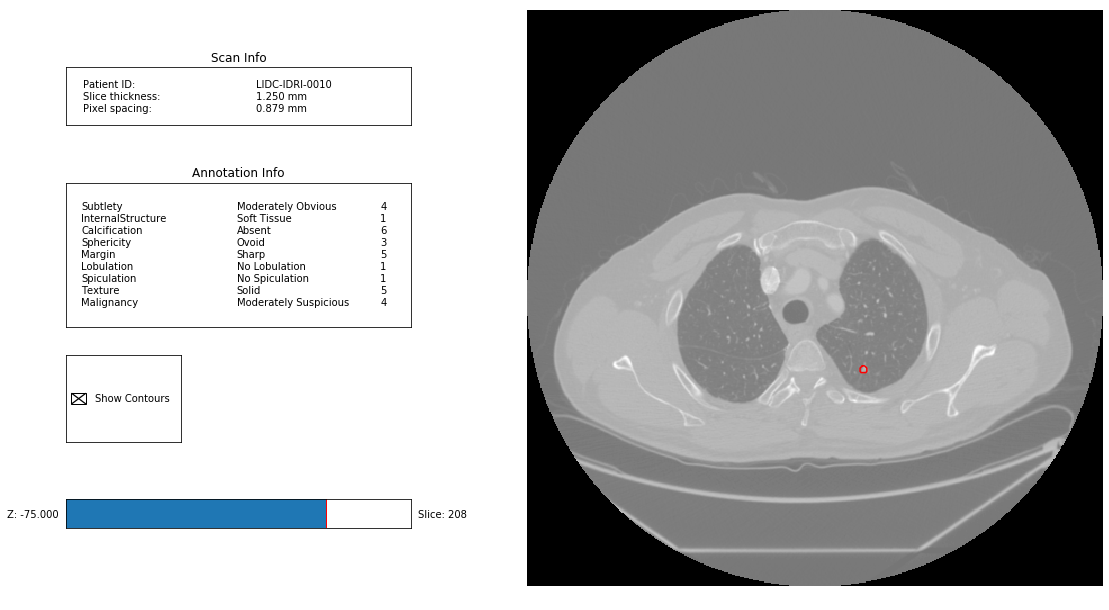

In [10]:
annotation_1.visualize_in_scan()

# Get Annotation consensus information

Loading dicom files ... This may take a moment.
(slice(292, 348, None), slice(275, 326, None), slice(207, 213, None))


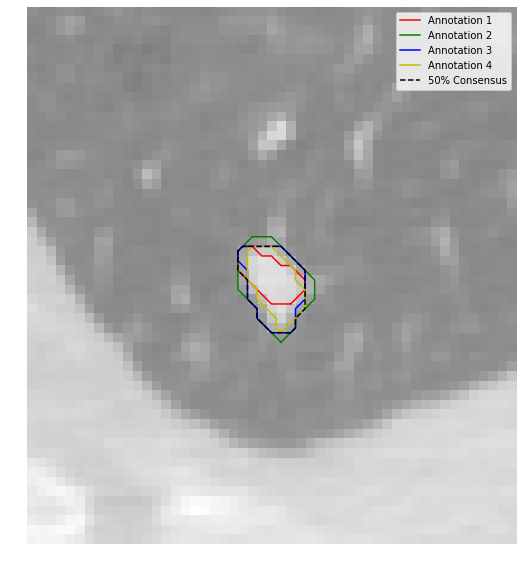

In [11]:
vol = scan.to_volume()

# Cluster the annotations for the scan, and grab one.
nods = scan.cluster_annotations()
anns = nods[2]

# Perform a consensus consolidation and 50% agreement level.
# We pad the slices to add context for viewing.
cmask,cbbox,masks = consensus(anns, clevel=0.5,
                              pad=[(20,20), (20,20), (0,0)])

print(cbbox)

# Get the central slice of the computed bounding box.
k = int(0.5*(cbbox[2].stop - cbbox[2].start))

# Set up the plot.
fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(vol[cbbox][:,:,k], cmap=plt.cm.gray, alpha=0.5)

# Plot the annotation contours for the kth slice.
colors = ['r', 'g', 'b', 'y']
for j in range(len(masks)):
    for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
        label = "Annotation %d" % (j+1)
        plt.plot(c[:,1], c[:,0], colors[j], label=label)

# Plot the 50% consensus contour for the kth slice.
for c in find_contours(cmask[:,:,k].astype(float), 0.5):
    plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()

# Get annotation mask

In [23]:
print(vol.shape)
cmask, cbbox, _ = consensus(anns, clevel=0.5)
print(cmask.shape)
print(cbbox)

(512, 512, 277)
(16, 11, 6)
(slice(312, 328, None), slice(295, 306, None), slice(207, 213, None))


In [24]:
cmask_full = np.zeros(vol.shape)
cmask_full[cbbox] = cmask
print(cmask_full.shape, np.unique(cmask_full))

(512, 512, 277) [0. 1.]


# Export to nrrd

In [39]:
import os, glob
import nrrd
# Load header from NRRD
data_path = "/wmlce/data/medical-datasets/LIDC-IDRI"
scan_path = glob.glob(os.path.join(data_path, pid, "*", "*", pid + "_CT.nrrd"))[0]
print(scan_path)
header = nrrd.read_header(scan_path)
# Write consensus to nrrd
cmask_full = np.swapaxes(cmask_full, 0, 1)
print(cmask_full.shape)
nrrd.write("test.nrrd", cmask_full, header=header)

/wmlce/data/medical-datasets/LIDC-IDRI/LIDC-IDRI-0010/1.3.6.1.4.1.14519.5.2.1.6279.6001.303099231937480740934110243375/1.3.6.1.4.1.14519.5.2.1.6279.6001.416701701108520592702405866796/LIDC-IDRI-0010_CT.nrrd
(512, 512, 277)
